In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# set up variables

#units: km, s

T = 20 #s
cl = 0.5 #km
beta = np.zeros((8,)) #ratio of off-ramp vehicles
beta[5] = 0.4
q = pd.DataFrame(0, index= range(300), columns= range(8)).astype('float') #veh/s flow to next cell
n = pd.DataFrame(0, index= range(301), columns= range(8)).astype('float') #number of vehicles in cell
q0 = np.zeros((300)) #veh/s flow into first cell
q0max = 6000/3600
d = pd.DataFrame(0, index= range(300), columns= range(2)).astype('float') #veh/s demand of space from ramp and start
for i in range(300): 
    if i < 45:
        d[0][i] = (1900/3600)*(1/900)*(20*i)
        d[1][i] = (3800/3600)*(1/900)*(20*i)
    elif i >= 45 and i < 135:
        d[0][i] = 1900/3600
        d[1][i] = 3800/3600
    elif i >= 135 and i < 180:
        d[0][i] = (1900/3600)*(1 - (20*(i - 135))/900)
        d[1][i] = (3800/3600)*(1 - (20*(i - 135))/900)
    elif i >= 180:
        d[0][i] = 0
        d[1][i] = 0
kj = np.array([360, 360, 360, 360, 240, 240, 240, 240]) #veh/km jam density
qmax = np.array([6000/3600, 6000/3600, 6000/3600, 6000/3600, 4000/3600, 4000/3600, 4000/3600, 4000/3600]) #veh/s max flow
v_temp = (6000/3600)/72 #km/s
w_temp = (6000/3600)/288 #km/s
vff = np.full((8,), v_temp) #km/s free flow speed
w = np.full((8,), w_temp) #km/s shockwave speed
#vff[3] = (4000/3600)/72
#w[3] = (4000/3600)/288
v = pd.DataFrame(0, index= range(300), columns= range(8)).astype('float') #km/s real speed of vehicles
N = pd.DataFrame(0, index= range(301), columns= range(2)).astype('float') #number of vehicles at queue at ramp and start
ramp = np.zeros((300)) #veh/s flow of vehicles entering from ramp at cell 1

In [3]:
for i in range(300):
    # calculate flow from the start to cell 0
    q0[i] = min(d[1][i] + (N[1][i]/T), q0max, w[0]*(kj[0] - (n[0][i]/cl)))
    
    # calculate flows from cell 0 and ramp to cell 1 
    q0_temp = min(vff[0]*(n[0][i]/cl), w[1]*(kj[1] - (n[1][i]/cl)), qmax[1])
    ramp_temp = d[0][i] + (N[0][i]/T)
    if (q0_temp + ramp_temp) <= (w[1]*(kj[1] - (n[1][i]/cl))):
        q[0][i] = q0_temp
        ramp[i] = ramp_temp
    else:
        q[0][i] = (q0_temp/(q0_temp + ramp_temp))*(w[1]*(kj[1] - (n[1][i]/cl)))
        ramp[i] = (ramp_temp/(q0_temp + ramp_temp))*(w[1]*(kj[1] - (n[1][i]/cl)))
        
    # calculate flows from cell 1 ~ 7
    for j in range(1, 7):
        q[j][i] = min((1 - beta[j])*vff[j]*(n[j][i]/cl), w[j + 1]*(kj[j + 1] - (n[j + 1][i]/cl)), qmax[j])
    q[7][i] = min((1 - beta[7])*vff[7]*(n[7][i]/cl), qmax[7])
    
    # calculate virtual queue at ramp and start at i + 1
    N[0][i + 1] = N[0][i] + T*(d[0][i] - ramp[i])
    N[1][i + 1] = N[1][i] + T*(d[1][i] - q0[i])
    
    # calculate number of vehicles within cells 0 ~ 7 at i + 1
    n[0][i + 1] = n[0][i] + T*(q0[i] - q[0][i])
    n[1][i + 1] = n[1][i] + T*(q[0][i] + ramp[i] - q[1][i])
    for j in range(2, 8):
        n[j][i + 1] = n[j][i] + T*(q[j - 1][i] - (q[j][i]/(1 - beta[j])))

<ipython-input-4-fafd54f10148>:33: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax3.plot_surface(X, Y, Z3, rstride=1, cstride=1, facecolors = my_col, linewidth=0, antialiased=False)


Text(0.5, 0, 'v, km/h')

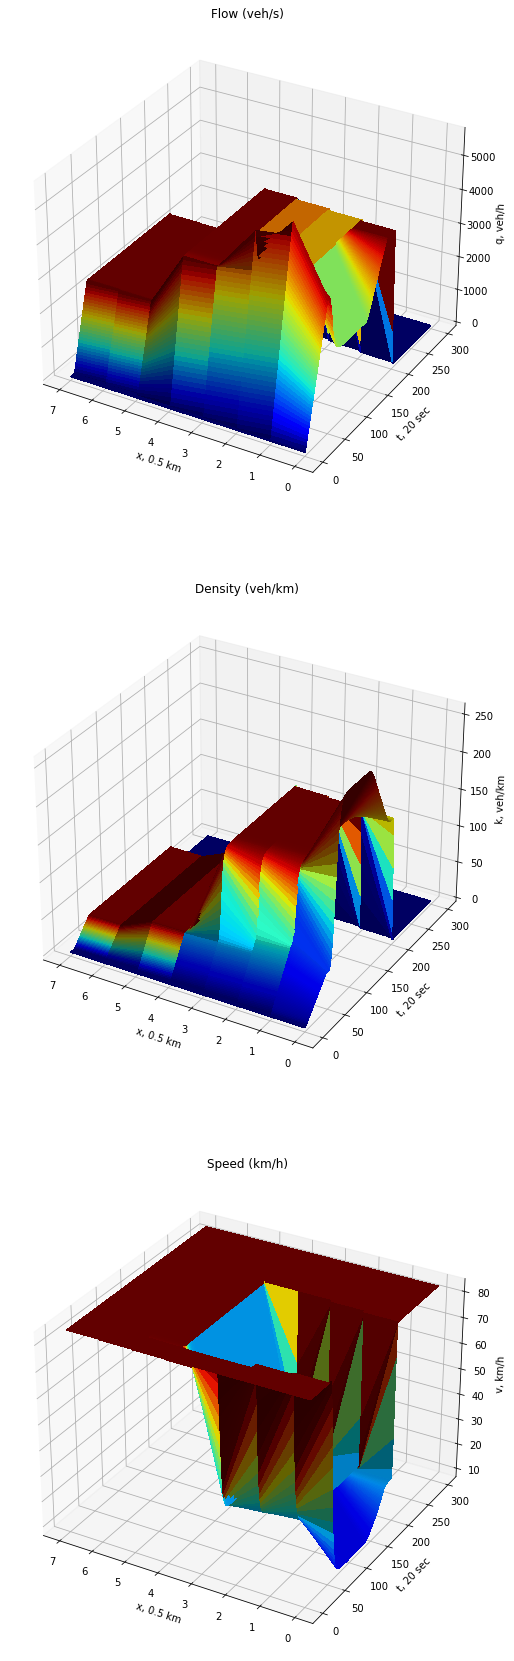

In [4]:
x = q.columns
y = q.index
X, Y = np.meshgrid(x, y)
Z = q*3600
k = n[:][0:300]/0.5
Z2 = k
Z3 = (Z/(1 - beta))/Z2

fig1 = plt.figure(figsize=(10, 30))

ax = fig1.add_subplot(311, projection='3d')
ax.title.set_text('Flow (veh/s)')
ax.invert_xaxis()
my_col = cm.jet(Z/np.amax(Z))
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors = my_col, linewidth=0, antialiased=False)
ax.set_xlabel('x, 0.5 km')
ax.set_ylabel('t, 20 sec')
ax.set_zlabel('q, veh/h')

ax2 = fig1.add_subplot(312, projection='3d')
ax2.title.set_text('Density (veh/km)')
ax2.invert_xaxis()
my_col = cm.jet(Z2/np.amax(Z2))
ax2.plot_surface(X, Y, Z2, rstride=1, cstride=1, facecolors = my_col, linewidth=0, antialiased=False)
ax2.set_xlabel('x, 0.5 km')
ax2.set_ylabel('t, 20 sec')
ax2.set_zlabel('k, veh/km')

ax3 = fig1.add_subplot(313, projection='3d')
ax3.title.set_text('Speed (km/h)')
ax3.invert_xaxis()
my_col = cm.jet(Z3/np.amax(Z3))
ax3.plot_surface(X, Y, Z3, rstride=1, cstride=1, facecolors = my_col, linewidth=0, antialiased=False)
ax3.set_xlabel('x, 0.5 km')
ax3.set_ylabel('t, 20 sec')
ax3.set_zlabel('v, km/h')

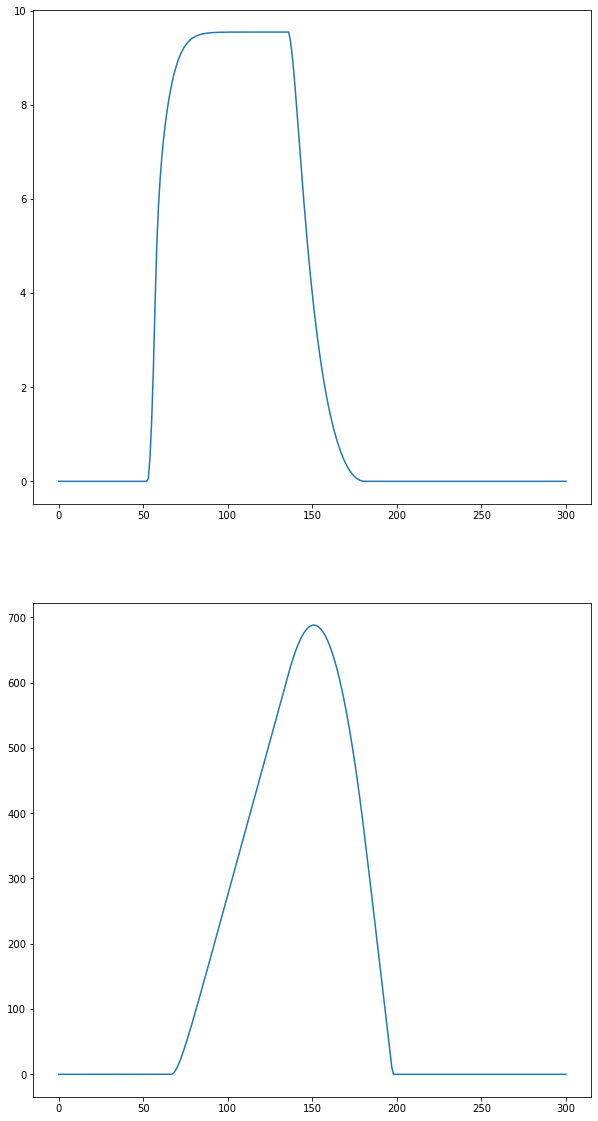

In [5]:
fig2 = plt.figure(figsize=(10, 20))

sub1 = fig2.add_subplot(211)
sub1.plot(N[0])

sub2 = fig2.add_subplot(212)
sub2.plot(N[1])

In [6]:
VKT = q.sum().sum()*(T*cl)
VHT = k.sum().sum()*(T*cl)*(1/3600) + N.sum().sum()*T/3600

print('VKT =', VKT, 'veh*km, VHT =', VHT, 'veh*hr')

VKT = 13822.500000000018 veh*km, VHT = 692.7966998632063 veh*hr
